In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [2]:
userSchema = StructType() \
        .add("window",StructType()\
             .add("start",TimestampType())\
             .add("end",TimestampType()))\
        .add("system", StringType())\
        .add("count", LongType())

In [3]:
raw_data = spark\
.readStream.format("parquet")\
.schema(userSchema)\
.load("/cms/users/carizapo/ming/groupdata_cmsweb_logs");
raw_data.printSchema()

root
 |-- window: struct (nullable = true)
 |    |-- start: timestamp (nullable = true)
 |    |-- end: timestamp (nullable = true)
 |-- system: string (nullable = true)
 |-- count: long (nullable = true)



In [4]:
raw_data_match = raw_data.withColumn('date',col("window.start")).drop(col("window"))\

In [5]:
raw_data_flow = raw_data.writeStream.queryName("hdfs").outputMode("Append").format("memory").start()

In [10]:
raw_data_flow.lastProgress

{'id': '72ce3a7f-9da8-4fb4-b5b9-1bcc1202d73c',
 'runId': '38590738-3ff3-430f-a5af-df2a9f31c2b1',
 'name': 'hdfs',
 'timestamp': '2019-07-12T13:08:17.926Z',
 'batchId': 1,
 'numInputRows': 0,
 'inputRowsPerSecond': 0.0,
 'processedRowsPerSecond': 0.0,
 'durationMs': {'getOffset': 807, 'triggerExecution': 807},
 'stateOperators': [],
 'sources': [{'description': 'FileStreamSource[hdfs://analytix/cms/users/carizapo/ming/groupdata_cmsweb_logs]',
   'startOffset': {'logOffset': 0},
   'endOffset': {'logOffset': 0},
   'numInputRows': 0,
   'inputRowsPerSecond': 0.0,
   'processedRowsPerSecond': 0.0}],
 'sink': {'description': 'MemorySink'}}

In [13]:
alerts = spark.sql("select * from hdfs")
# alerts.show()

In [14]:
from pyspark.sql.window import Window as W
raw_data_id = alerts.select("system").distinct()
windowSpec = W.orderBy("system")
raw_data_id=raw_data_id.withColumn("systemID", row_number().over(windowSpec)).withColumnRenamed("system","tempSystem")

In [15]:
alerts_df=alerts\
.join(raw_data_id, raw_data_id.tempSystem == alerts.system)\
.withColumn('date',col("window.start")).drop(col("window"))\
.drop(raw_data_id.tempSystem)

In [ ]:
alerts_df.show()

In [16]:
alerts_pd=alerts_df.toPandas()

In [82]:
import matplotlib.pyplot as plt
import pandas as pd
filter_data=alerts_pd[(alerts_pd.system =='dbs')]

In [83]:
filter_data.set_index('date', inplace=True)

In [84]:
prep=filter_data[['count']]
# print(prep.sort_values(by='date'))

In [85]:
# prep.dropna()
prep.isnull().values.any()

False

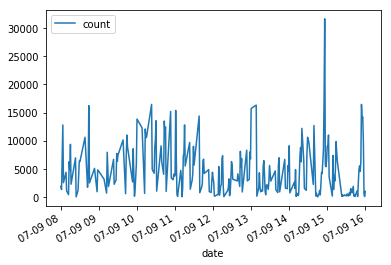

In [105]:
%matplotlib inline

prep_fix=prep.loc['2019-07-9 08:00:00':'2019-07-9 16:00:00']
prep_fix.plot()
# prep.plot()

In [89]:
import numpy as np
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [90]:
# fix random seed for reproducibility
np.random.seed(7)

In [91]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(prep_fix)

In [94]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

178 88


In [95]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [96]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [97]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [107]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [99]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 4667.72 RMSE
Test Score: 4019.74 RMSE


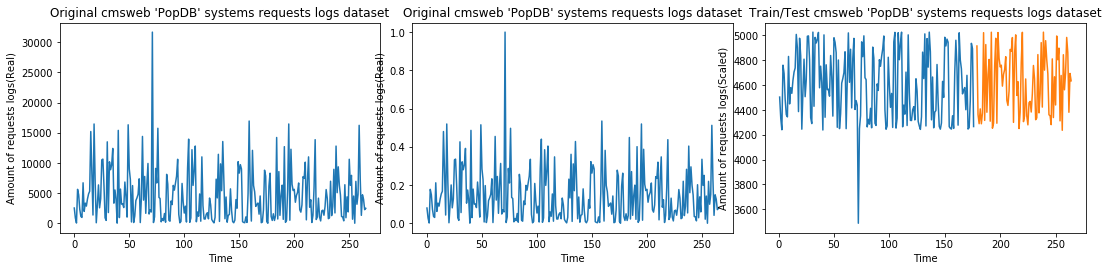

In [104]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions

fig, (ax1, ax2,ax3) = plt.subplots(nrows=1, ncols=3)

ax1.plot(scaler.inverse_transform(dataset))
ax1.set_title('Original cmsweb \'PopDB\' systems requests logs dataset')
ax1.set_ylabel('Amount of requests logs(Real)')
ax1.set_xlabel('Time')
# plt.subplot(1, 2, 1)
# ax1.plot(scaler.inverse_transform(dataset))
ax2.plot(dataset)
ax2.set_title('Original cmsweb \'PopDB\' systems requests logs dataset')
ax2.set_ylabel('Amount of requests logs(Real)')
ax2.set_xlabel('Time')

# plt.subplot(1, 2, 2)
ax3.plot(trainPredictPlot)
ax3.plot(testPredictPlot)
ax3.set_title('Train/Test cmsweb \'PopDB\' systems requests logs dataset')
ax3.set_ylabel('Amount of requests logs(Scaled)')
ax3.set_xlabel('Time')

plt.subplots_adjust(bottom=0.15,right = 2.5, wspace=0.1)
plt.show()

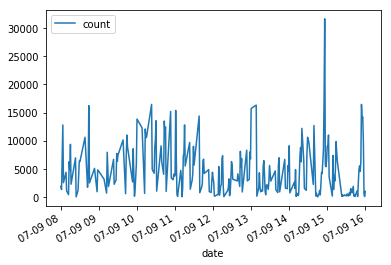

In [106]:
prep_fix.plot()

In [108]:
# print(dataset)